# **Trabalho de Extra√ß√£o**
##### **Autores:** C√°tia Ros√°rio (pg57791), Vanessa Rodriguez (pg49131), Andr√© Dias (pg55127)
##### **Data**: 2025-06-13



# Introdu√ß√£o

Esta an√°lise visa investigar um conjunto de compostos qu√≠micos com base nos seus descritores moleculares e respetiva atividade mutag√©nica, conforme avaliada pelo teste de Ames. Ap√≥s o pr√©-processamento dos dados ‚Äî que incluiu a remo√ß√£o de vari√°veis constantes e a normaliza√ß√£o dos descritores restantes ‚Äî procedeu-se √† sumariza√ß√£o do conjunto de dados atrav√©s de estat√≠sticas descritivas e visualiza√ß√µes, com foco em compreender a distribui√ß√£o das vari√°veis e a rela√ß√£o entre os descritores e a vari√°vel alvo.

De seguida, foram realizadas an√°lises estat√≠sticas multivariadas, incluindo redu√ß√£o de dimensionalidade - como PCA, UMAP e t-SNE - e m√©todos de clustering n√£o supervisionado - como o K-Means, para investigar padr√µes latentes nos dados.

Adicionalmente, foram identificadas as vari√°veis mais informativas para a classifica√ß√£o mutag√©nica e realizada uma visualiza√ß√£o estrutural das mol√©culas com o aux√≠lio da biblioteca RDKit, permitindo uma an√°lise qu√≠mica mais interpret√°vel dos compostos centrais de cada grupo.

Este pipeline visa oferecer uma vis√£o abrangente dos fatores estruturais associados √† mutagenicidade e pode servir como base para futuras aplica√ß√µes em toxicologia preditiva e qu√≠mica computacional.


## Dataset AMES
208 descritores moleculares num√©ricos no ficheiro ames_features.csv, calculados a partir de representa√ß√µes moleculares (SMILES).
Ficheiro de sa√≠das ames_outputs.csv com identificador do composto (ids), representa√ß√£o qu√≠mica da estrutura (smiles) e vari√°vel alvo bin√°ria (0 ou 1) representando se a mol√©cula √© mutag√™nica ou n√£o segundo o teste de Ames (Y).


## 1. Carregamento e Pr√©-processamento dos Dados

### 1.0 Carregamento de Bibliotecas

In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold



### 1.1 Carregamento dos dados

In [ ]:
# Carregue os ficheiros CSV
features_df = pd.read_csv("C:\\Users\\UTILIZADOR\\Desktop\\2¬∫ trabalho EXT\\ames_features.csv")
outputs_df = pd.read_csv("C:\\Users\\UTILIZADOR\\Desktop\\2¬∫ trabalho EXT\\ames_outputs.csv")

In [ ]:
# Exibir as primeiras 5 linhas de features_df com estilo simples
display(features_df.head().style
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', 'lightsteelblue'),
                      ('color', '#333'),
                      ('font-weight', 'bold'),
                      ('font-size', '14px')]
        }])
        .set_properties(**{'text-align': 'center', 'font-size': '12px'}))

# Exibir as primeiras 5 linhas de outputs_df com o mesmo estilo
display(outputs_df.head().style
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', 'lightsteelblue'),
                      ('color', '#333'),
                      ('font-weight', 'bold'),
                      ('font-size', '14px')]
        }])
        .set_properties(**{'text-align': 'center', 'font-size': '12px'}))


**1. ames_features.csv**

Cont√©m 208 descritores moleculares num√©ricos extra√≠dos a partir da representa√ß√£o SMILES das mol√©culas. Esses descritores incluem:

    - Propriedades f√≠sico-qu√≠micas b√°sicas (ex: peso molecular, logP, n√∫mero de √°tomos).
    - Descritores topol√≥gicos (como Chi, Kappa, √≠ndice de conectividade).
    - Descritores eletr√≥nicos (ex: cargas parciais, polarizabilidade).
    - Descritores 2D BCUT (Burden-CAS University of Texas).
    - Propriedades estruturais (ex: n√∫mero de an√©is arom√°ticos, √°tomos pesados, liga√ß√µes duplas).
    - Descritores de superf√≠cie (como TPSA e ASA).

**Formato:**

    Linhas: compostos qu√≠micos
    Colunas: descritores
    Indexado por ids

**2. ames_outputs.csv**

Cont√©m as informa√ß√µes de sa√≠da para cada mol√©cula:

    ids: Identificador √∫nico da mol√©cula
    smiles: Representa√ß√£o simplificada da estrutura qu√≠mica
    Y: Vari√°vel alvo bin√°ria (1 = mutag√©nico, 0 = n√£o mutag√©nico), baseada no teste de Ames, um ensaio biol√≥gico padr√£o para avalia√ß√£o de mutagenicidade.

**Import√¢ncia da vari√°vel Y:**

    - Usada para modelagem preditiva (classifica√ß√£o bin√°ria)
    - Pode refletir mecanismos estruturais associados √† toxicidade gen√©tica

### 1.2 Pr√©-Processamento

#### 1.2.1 Verifica√ß√£o e tratamento de valores ausentes

In [ ]:
# Dimens√µes dos datasets
print("Features:", features_df.shape)
print("Outputs:", outputs_df.shape)

Features: (7273, 208)
Outputs: (7273, 3)


In [ ]:
# Verificar tipos e valores ausentes
print(features_df.info())
print(outputs_df.info())

print("Valores ausentes em features:", features_df.isnull().sum().sum())
print("Valores ausentes em outputs:", outputs_df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7273 entries, 0 to 7272
Columns: 208 entries, MaxEStateIndex to fr_urea
dtypes: float64(208)
memory usage: 11.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7273 entries, 0 to 7272
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     7273 non-null   object
 1   smiles  7273 non-null   object
 2   Y       7273 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 170.6+ KB
None
Valores ausentes em features: 0
Valores ausentes em outputs: 0


#### 1.2.2 Remo√ß√£o de colunas constantes ou nulas

In [ ]:
features_clean = features_df.drop(columns=['SMR_VSA8', 'SlogP_VSA9', 'fr_prisulfonamd'])

 #### 1.2.3 Normaliza√ß√£o dos dados

In [ ]:
# Normalizar os dados
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clean)

# Opcional: transformar de volta em DataFrame
features_scaled_df = pd.DataFrame(features_clean, columns=features_clean.columns)

## 2. Sumariza√ß√£o e Explora√ß√£o dos Dados

### 2.1 Estat√≠sticas Descritivas dos Descritores

In [ ]:
desc_stats = features_clean.describe()

desc_stats.style\
    .set_properties(**{
        'font-family': 'Arial',
        'font-size': '9pt',
        'text-align': 'center'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightsteelblue'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold'),
                                     ('border', '1px solid #ccc')]}
    ])\
    .set_caption("Estat√≠sticas Descritivas das Features")


Nesta tabela podemos observar as estat√≠sticas descritivas - contagem, m√©dia, desvio-padr√£o, quartis e m√≠nimos e m√°ximos - para cada feature ap√≥s retirar colunas nulas.

**Amostragem Consistente:**
- Todas as vari√°veis apresentadas possuem 7273 observa√ß√µes, o que indica que n√£o h√° dados em falta neste subconjunto ap√≥s a limpeza inicial

**Distribui√ß√£o de Valores:**
- Para a maioria dos descritores, √© poss√≠vel observar uma varia√ß√£o significativa nos valores m√≠nimos e m√°ximos, o que indica heterogeneidade nas propriedades moleculares

- Certas features podem assumir valores negativos, sugerindo descritores com propriedades eletr√≥nicas direcionais

**Amplitude e Assimetria:**
- A diferen√ßa entre os quartis e os valores extremos (m√≠nimo e m√°ximo) sugere que algumas vari√°veis podem apresentar distribui√ß√µes assim√©tricas ou presen√ßa de outliers

**Escalas Diversas:**
- Os descritores est√£o em escalas muito diferentes, com alguns variando em intervalos pequenos - normaliza√ß√£o necess√°ria antes de ML

In [ ]:
desc_scaled = features_scaled_df.describe()

desc_scaled.style\
    .set_properties(**{
        'font-family': 'Arial',
        'font-size': '9pt',
        'text-align': 'center'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightsteelblue'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold'),
                                     ('border', '1px solid #ccc')]}
    ])\
    .set_caption("Estat√≠sticas Descritivas das Features")

Nesta tabela podemos observar as estat√≠sticas descritivas - contagem, m√©dia, desvio-padr√£o, quartis e m√≠nimos e m√°ximos - para cada feature ap√≥s o escalonamento.

**Amostragem Consistente:**
- Todas as vari√°veis apresentadas possuem 7273 observa√ß√µes, o que confirma a consit√™ncia do conjunto de dados ap√≥s o pr√©-processamento e escalonamento. N√£o h√° dados ausentes

**Distribui√ß√£o de Valores:**
- O escalonamento reduziu as diferen√ßas entre escalas. A m√©dia de muitas variav√©is est√° pr√≥zima de zero e o desvio padr√£o tende a 1, o que √© t√≠pico de t√©cnicas como padroniza√ß√£o Z-score sendo que isto permite que algoritmos de aprendizado de m√°quina tratem todas as vari√°veis de forma equitativa

**Amplitude e Assimetria:**
- Apesar da padroniza√ß√£o, ainda √© poss√≠vl observar valores m√°ximos e m√≠nimos distantes, indicando que algumas vari√°veis mant√™m distribui√ß√µes assim√©tricas ou a presen√ßa de outliers, o que j√° esperado visto que o escolamento n√£o remove outliers, apenas ajusta a escala

**Escalas Uniformizadas:**
- A padroniza√ß√£o garantiu que as features estejam em escalas compar√°veis, o que √© fundamental para algoritmos sens√≠veis √† escala, como por exemplo a m√©dia das variav√©is como MolWt, TPSA, NumHA, entre outras, foi centrada em torno de zero e o desvio padr√£o est√° pr√≥ximo de 1, evidenciando que a transforma√ß√£o foi bem-sucedida.

### 2.1 An√°lise da vari√°vel alvo

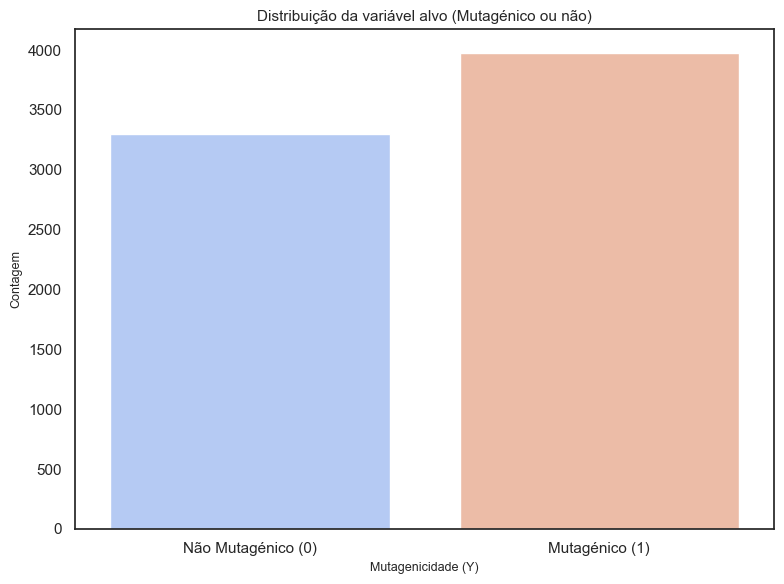

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(style="white")
sns.countplot(x='Y', data=outputs_df, palette='coolwarm')
plt.title('Distribui√ß√£o da vari√°vel alvo (Mutag√©nico ou n√£o)', fontsize=11)
plt.xlabel('Mutagenicidade (Y)', fontsize=9)
plt.ylabel('Contagem', fontsize=9)
plt.xticks(ticks=[0, 1], labels=['N√£o Mutag√©nico (0)', 'Mutag√©nico (1)'])
plt.tight_layout()
plt.show()

O gr√°fico de barras gerado com a biblioteca Seaborn em Python. Analisa a vari√°vel alvo "Y", indicando se uma subst√¢ncia √© mutag√©nica ou n√£o. Uma das barras representa os casos n√£o mutag√©nicos ("N√£o Mutag√©nico (0)") e a outra os casos mutag√©nicos ("Mutag√©nico (1)"). O gr√°fico sugere que h√° mais inst√¢ncias mutag√©nicas do que n√£o mutag√©nicas no conjunto de dados.

### 2.2 Visualiza√ß√£o de descritores moleculares





#### 2.2.1 An√°lise das primeiras 6 vari√°veis - Histogramas

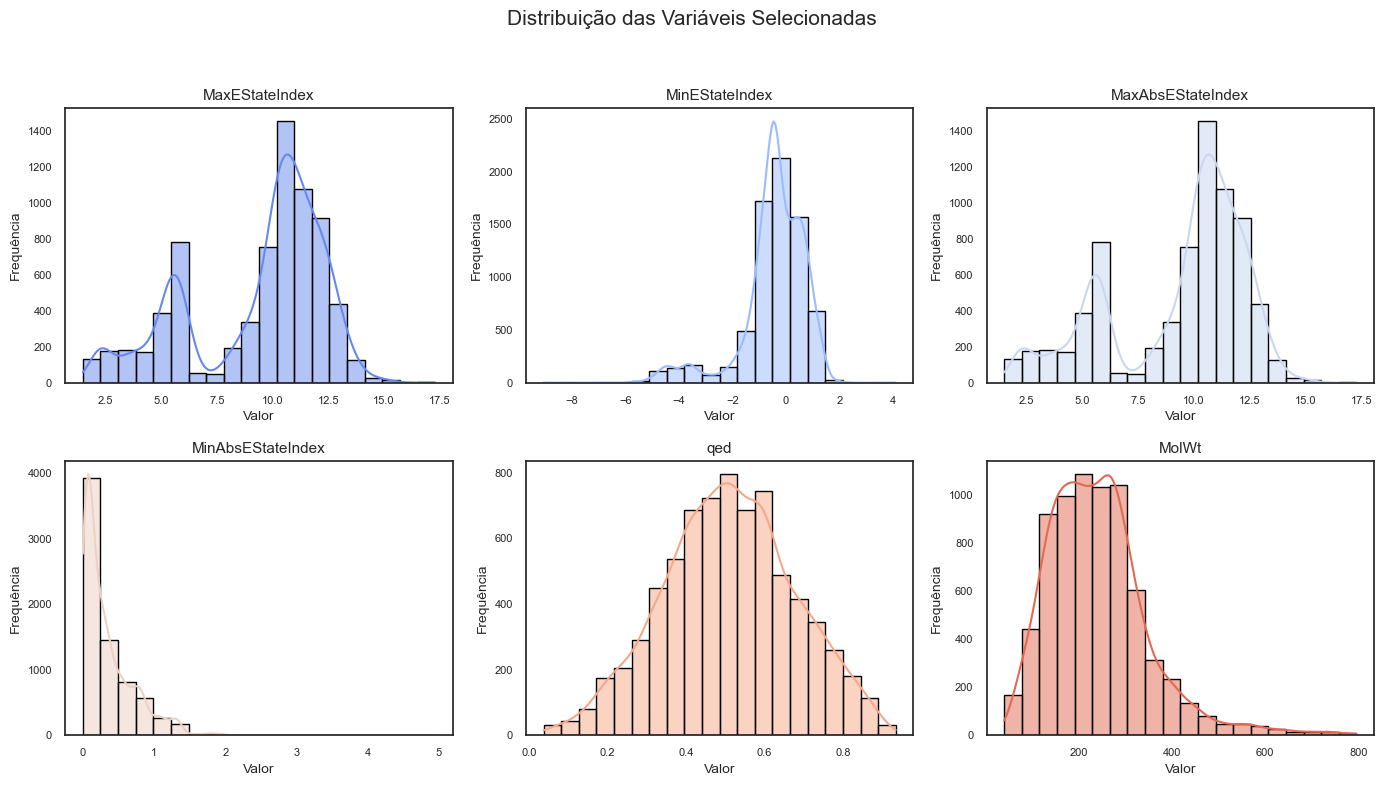

In [ ]:
# Selecionar as primeiras 6 vari√°veis
selected_features = features_clean.columns[:6]

# Estilo limpo
sns.set(style="whitegrid")

# Cores da paleta coolwarm (altern√¢ncia entre elas)
colors = sns.color_palette("coolwarm", len(selected_features))
sns.set(style="white")
# Criar histogramas 3x2
plt.figure(figsize=(14, 8))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(features_clean[feature], kde=True, bins=20, color=colors[i], edgecolor='black')
    plt.title(feature, fontsize=11)
    plt.xlabel('Valor', fontsize=10)
    plt.ylabel('Frequ√™ncia', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.suptitle('Distribui√ß√£o das Vari√°veis Selecionadas', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Os histogramas apresentados refletem a distribui√ß√£o de seis vari√°veis selecionadas no conjunto de dados. Aqui est√£o algumas observa√ß√µes sobre cada um deles:

**MaxEStateIndex:** Apresenta uma distribui√ß√£o bimodal, com picos em torno de 5 e 10. Isso sugere que h√° dois grupos distintos de valores predominantes nesta vari√°vel.

**MinEStateIndex:** Distribui√ß√£o unimodal com um pico ao redor de -2. A maioria dos valores parece concentrar-se nesse intervalo.

**MaxAbsEStateIndex:** Semelhante ao MaxEStateIndex, exibe uma distribui√ß√£o bimodal com picos pr√≥ximos de 5 e 10.

**MinAbsEStateIndex:** Exibe uma distribui√ß√£o unimodal, com um pico principal em torno de 0,5, indicando concentra√ß√£o de valores nesse ponto.

**qed:** Apresenta uma distribui√ß√£o unimodal centrada em 0,6. Isso sugere que grande parte das amostras tem valores pr√≥ximos desse n√∫mero.

**MolWt:** A distribui√ß√£o desta vari√°vel tamb√©m √© unimodal, com um pico ao redor de 300. Isso indica que a maioria das mol√©culas no conjunto de dados tem uma massa molecular pr√≥xima desse valor.

#### 2.2.2 An√°lise das primeiras 6 vari√°veis - Boxplots


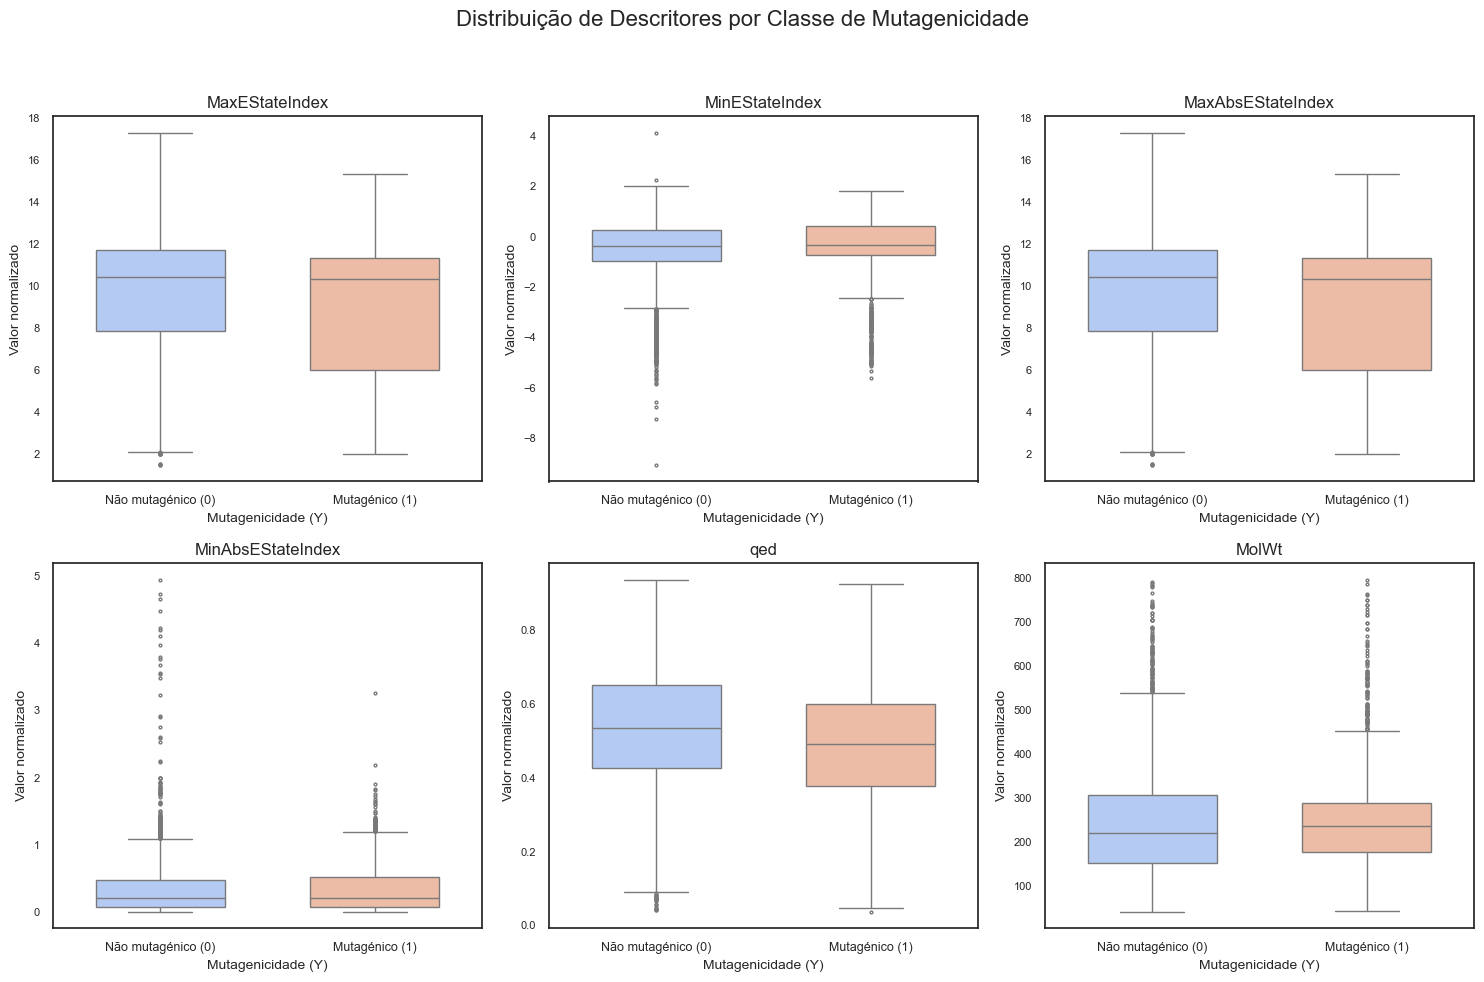

In [ ]:
# Selecionar as primeiras 6 features para visualiza√ß√£o
selected_features = features_clean.columns[:6]

# Estilo elegante
sns.set(style="white")

# Adicionar a vari√°vel alvo 'Y' a features_clean ANTES de usar para plotagem
# This line was moved from a later cell to ensure 'Y' is present.
features_clean['Y'] = outputs_df['Y']

# Criar boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    # Agora 'Y' est√° presente em features_clean
    sns.boxplot(x='Y', y=feature, data=features_clean, palette='coolwarm', width=0.6, fliersize=2)
    plt.title(f'{feature}', fontsize=12)
    plt.xlabel('Mutagenicidade (Y)', fontsize=10)
    plt.ylabel('Valor normalizado', fontsize=10)
    plt.xticks([0, 1], ['N√£o mutag√©nico (0)', 'Mutag√©nico (1)'], fontsize=9)
    plt.yticks(fontsize=8)

plt.suptitle('Distribui√ß√£o de Descritores por Classe de Mutagenicidade', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Estes boxplots comparam a distribui√ß√£o de v√°rios descritores entre classes mutag√©nicas e n√£o mutag√©nicas.

**MaxEStateIndex:** A classe n√£o mutag√©nica tende a apresentar um valor mediano ligeiramente maior em compara√ß√£o com a mutag√©nica.

**MinEStateIndex:** Os valores medianos s√£o semelhantes, mas a classe n√£o mutag√©nica tem uma faixa interquartil mais ampla.

**MaxAbsEStateIndex:** A classe n√£o mutag√©nica tem um valor mediano um pouco maior do que a mutag√©nica.

**MinAbsEStateIndex:** A classe n√£o mutag√©nica possui uma mediana maior e apresenta mais outliers.

**qed:** As duas classes possuem valores medianos e intervalos interquartis bastante similares.

**MolWt:** A classe n√£o mutag√©nica tende a ter uma mediana mais alta e uma distribui√ß√£o mais ampla do que a mutag√©nica.

### 2.3 Correla√ß√£o top 20 Features em fun√ß√£o de Y


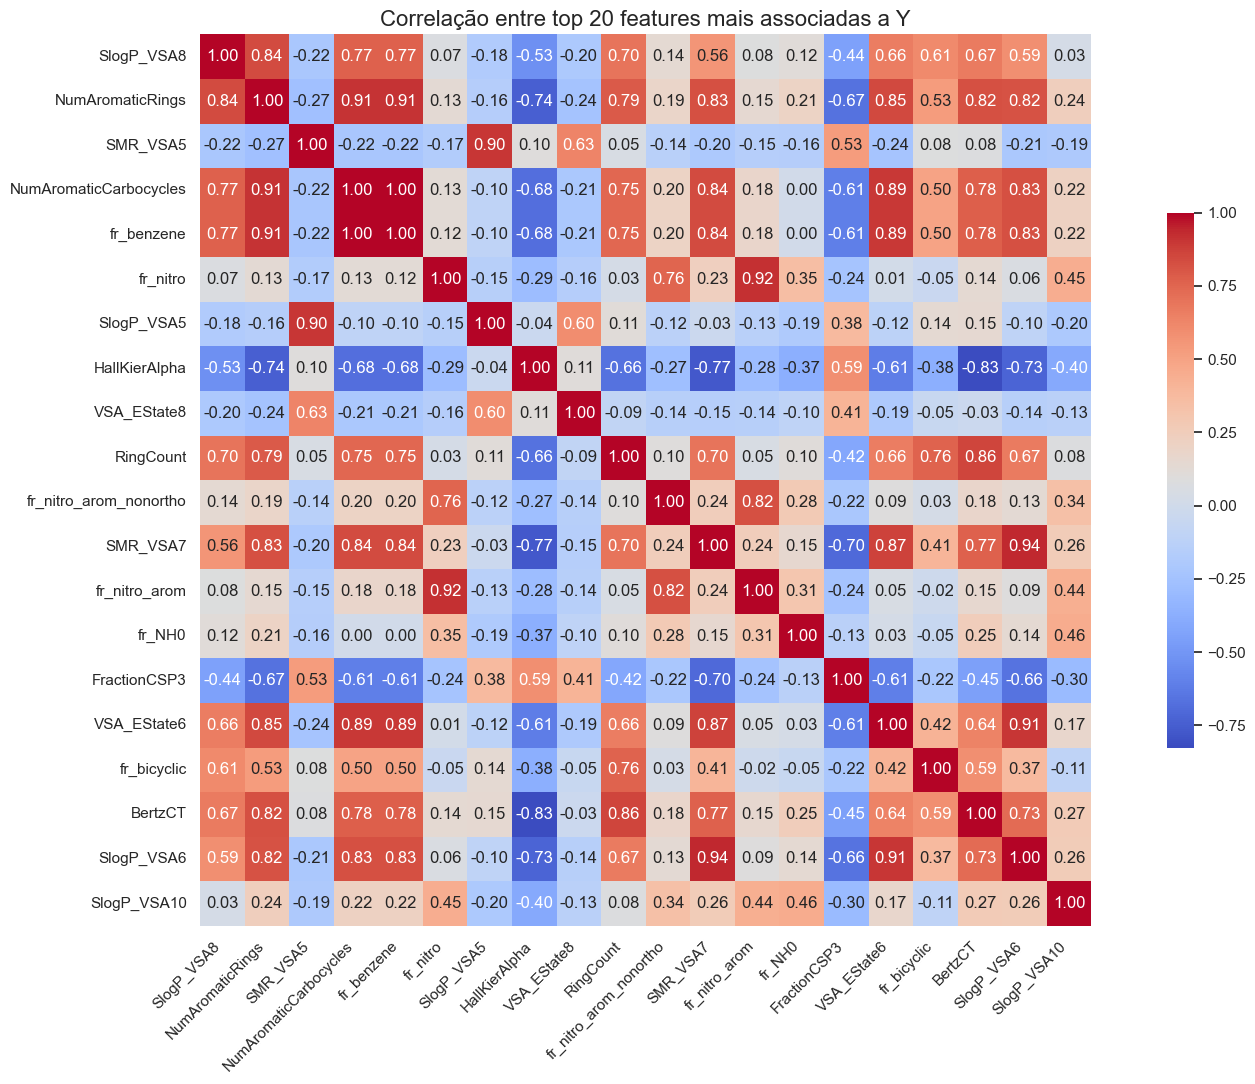

In [ ]:
# Garantir que Y est√° presente
features_clean['Y'] = outputs_df['Y']

# Calcular correla√ß√£o
corr = features_clean.corr()

# Selecionar top 20 vari√°veis mais correlacionadas com Y (ignorando Y)
top_corr = corr['Y'].abs().sort_values(ascending=False)[1:21]

# Subcorrela√ß√£o s√≥ com as vari√°veis selecionadas
top_corr_matrix = features_clean[top_corr.index].corr()

# Aumentar tamanho da figura
plt.figure(figsize=(16, 11))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .6})
plt.title("Correla√ß√£o entre top 20 features mais associadas a Y", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

O heatmap exibe a correla√ß√£o entre as 20 principais features mais associadas √† vari√°vel Y. Cada c√©lula da matriz mostra o coeficiente de correla√ß√£o entre um par de features, com valores que variam de -0.75 (indicando uma forte correla√ß√£o negativa - azul) at√© 1.00 (correla√ß√£o perfeita - vermelho). Essa disposi√ß√£o permite visualizar facilmente quais as features que se movem de maneira semelhante (valores positivos pr√≥ximos a 1) ou de forma oposta (valores negativos pr√≥ximos a -0.75).

**Grupo 1: Propriedades relacionadas √† aromaticidade:**

    NumAromaticRings, NumAromaticCarbocycles, fr_benzene, fr_nitro, fr_nitro_arom

- Correlacionadas positivamente com valores acima de 0.85.
- Essas features est√£o todas associadas a an√©is arom√°ticos ou grupos nitro, que s√£o conhecidos por contribuir para a mutagenicidade em compostos.

**Grupo 2: Descritores de SlogP e SMR:**

    SlogP_VSA5, SlogP_VSA6, SlogP_VSA8, SlogP_VSA10, SMR_VSA5, SMR_VSA7

- Correlacionam fortemente entre si (valores de 0.70 a 0.94), indicando que representam propriedades de superf√≠cie e lipofilicidade de forma redundante.
- O SlogP e SMR medem caracter√≠sticas semelhantes sob perspectivas diferentes (hidrofobicidade x momento refrativo).

**Grupo 3: Propriedades estruturais e topol√≥gicas:**

    RingCount, HallKierAlpha, VSA_EState6/8:

- Ligados a n√∫mero de an√©is, conectividade, estado eletr√≥nico, correlacionam moderadamente.

**Conclus√µes gerais:**
- Fortes agrupamentos de vari√°veis intercorrelacionadas
- Redund√¢ncia potencial entre descritores similares
- Presen√ßa de vari√°veis com alto poder discriminativo (aromaticidade, grupos funcionais)

A forte co-ocorr√™ncia entre an√©is arom√°ticos e grupos nitro sugere que motivos estruturais espec√≠ficos contribuem para mutagenicidade.

## 3. An√°lise Estat√≠stica Multivariada N√£o Supervisionada

### 3.1 PCA (An√°lise de Componentes Principais)

Vari√¢ncia explicada por cada componente: [0.17022739 0.07935862]


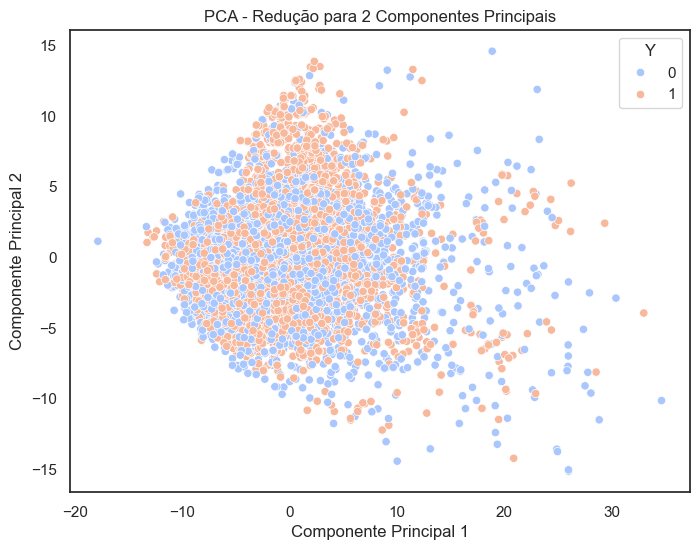

In [ ]:
# Aplicar PCA nos dados normalizados
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Transformar em DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Y'] = outputs_df['Y']  # adicionar a vari√°vel alvo para visualiza√ß√£o

# Vari√¢ncia explicada
print("Vari√¢ncia explicada por cada componente:", pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Y', data=pca_df, palette='coolwarm')
plt.title('PCA - Redu√ß√£o para 2 Componentes Principais')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

O gr√°fico mostra uma redu√ß√£o de dimensionalidade do dataset para 2 componentes principais (PC1 e PC2), com os pontos coloridos de acordo com a vari√°vel alvo Y:

    üîµ Y = 0 (n√£o mutag√©nico)
    üü† Y = 1 (mutag√©nico)

PC1 explica ‚âà17.0% da vari√¢ncia
PC2 explica ‚âà7.9%

- Juntas, essas duas componentes explicam apenas ‚âà25% da vari√¢ncia total. Esta baixa vari√¢ncia pode ser devida aos dados serem altamente multidimensionais.

As duas classes (Y = 0 e Y = 1) n√£o est√£o nitidamente separadas (sem clusters evidentes) - as nuvens de pontos se sobrep√µem fortemente.

A proje√ß√£o mostra alguma dispers√£o ao longo de PC1, mas PC2 n√£o acrescenta muito em termos de estrutura vis√≠vel.

Indica que PCA n√£o √© suficiente para discriminar entre mutag√©nicos e n√£o-mutag√©nicos. Isto acontece quando a separa√ß√£o entre classes n√£o √© linear ou as vari√°veis mais relevantes para a classifica√ß√£o n√£o s√£o aquelas com maior vari√¢ncia.

### 3.2 Clustering

#### 3.2.1 M√©todo do Catovelo para escolha de k

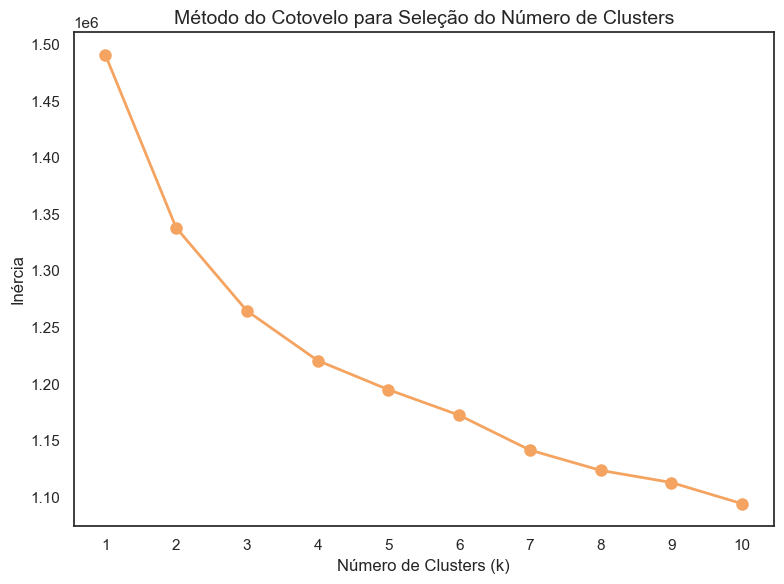

In [ ]:
# Calcular in√©rcia para k de 1 a 10
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Estilo elegante sem grid
sns.set(style='white')  # estilo limpo

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o', color='sandybrown', linewidth=2, markersize=8)
plt.xticks(K_range)
plt.title('M√©todo do Cotovelo para Sele√ß√£o do N√∫mero de Clusters', fontsize=14)
plt.xlabel('N√∫mero de Clusters (k)', fontsize=12)
plt.ylabel('In√©rcia', fontsize=12)
plt.tight_layout()
plt.show()

Eixo X: N√∫mero de clusters kk, variando de 1 a 10.
Eixo Y: In√©rcia (ou soma das dist√¢ncias quadradas intra-cluster), que mede o qu√£o compactos est√£o os clusters.
Linha laranja: Mostra a diminui√ß√£o da in√©rcia √† medida que aumentamos k.

O ponto onde o ganho de compacta√ß√£o (redu√ß√£o de in√©rcia) come√ßa a diminuir significativamente - K=2.

#### 3.2.2 K-means: clusters no espe√ßo PCA

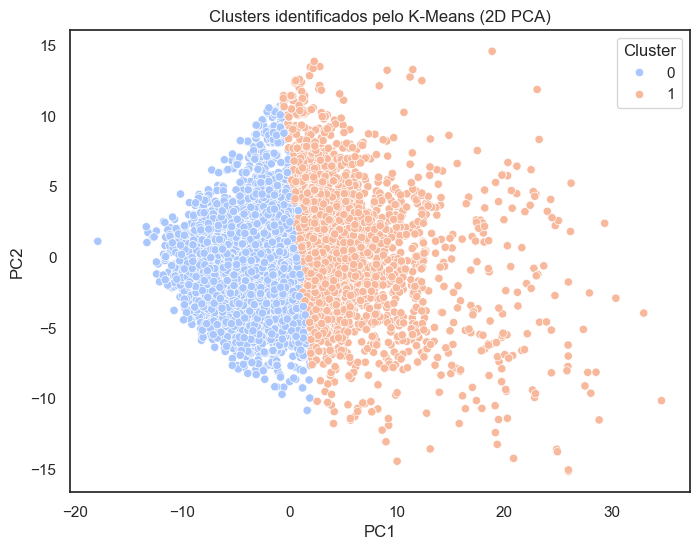

In [ ]:
# Vamos assumir 2 clusters como exemplo
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adicionar clusters ao DataFrame do PCA
pca_df['Cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='coolwarm')
plt.title('Clusters identificados pelo K-Means (2D PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

O gr√°fico mostra os clusters identificados pelo algoritmo K-Means ap√≥s redu√ß√£o de dimensionalidade por PCA.

    üîµ Cluster 0
    üü† Cluster 1

**Separa√ß√£o clara entre clusters:**
- A divis√£o entre os dois grupos √© visualmente percept√≠vel ao longo do eixo PC1.
- Isto sugere que os dados possuem estrutura latente que K-Means conseguiu capturar razoavelmente bem.

**Simetria dos dados:**
- O cluster azul e o laranja parecem quase espelhados em rela√ß√£o a PC1 = 0. Isso refor√ßa que o PCA ajudou a revelar a separa√ß√£o natural nos dados.

**Sobreposi√ß√£o parcial:**
- H√° uma zona de transi√ß√£o em torno de PC1 ‚âà 0 onde os clusters se sobrep√µem.
- Isso pode indicar que as fronteiras entre clusters n√£o s√£o perfeitamente lineares ‚Äî uma limita√ß√£o do K-Means, que assume fronteiras esf√©ricas.

### 3.3 Interpreta√ß√£o dos componentes principais

#### 3.3.1 Tabela com os 6 descritores com maior peso (PC1 e PC2)

In [ ]:
# Loadings dos componentes principais
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features_clean.columns[:205])

# Maiores contribuidores para PC1 e PC2
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(6)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(6)

In [ ]:
# Criar DataFrame combinado para exibir os top 6 descritores de PC1 e PC2
top_pc_df = pd.DataFrame({
    'Top PC1 Features': top_pc1.index,
    'PC1 Loadings': top_pc1.values,
    'Top PC2 Features': top_pc2.index,
    'PC2 Loadings': top_pc2.values
})

top_pc_df.style.set_caption("Top 6 Contribuidores para PC1 e PC2") \
               .format({'PC1 Loadings': '{:.4f}', 'PC2 Loadings': '{:.4f}'}) \
               .hide(axis='index') \
               .set_table_styles([
                   {'selector': 'caption',
                    'props': [('color', '#333'),
                              ('font-size', '16px'),
                              ('text-align', 'left'),
                              ('font-weight', 'bold'),
                              ('margin-bottom', '10px')]},
                   {'selector': 'th',
                    'props': [('background-color', 'lightsteelblue'),
                              ('padding', '8px')]},
                   {'selector': 'td',
                    'props': [('padding', '8px')]}
               ])



Os resultados apresentados mostram os seis descritores que mais contribu√≠ram para os dois primeiros componentes principais (PC1 e PC2), juntamente com os seus respectivos coeficientes de carga (loadings), que refletem o peso de cada vari√°vel na constru√ß√£o de cada componente.

**PC1:**
O PC1 parece estar fortemente associado a propriedades estruturais e topol√≥gicas gerais da mol√©cula, como n√∫mero de eletr√µes de val√™ncia, n√∫mero de √°tomos pesados e √≠ndices de conectividade (Chi0, Chi1, Chi0n). Essas vari√°veis s√£o indicativas da tamanho e forma da mol√©cula, influenciando sua complexidade estrutural.

**PC2:**
O PC2 √© dominado por descritores relacionados √† aromaticidade (e.g., fr_benzene, NumAromaticRings), logP (MolLogP, SlogP_VSA6), e propriedades eletr√≥nicas de superf√≠cie (VSA_EState6). Estes descritores capturam aspectos mais eletr√≥nicos e lipof√≠licos da mol√©cula, al√©m de sua propens√£o √† planaridade e estabilidade conferidas por an√©is arom√°ticos.

#### 3.3.2 Barplots dos descritores-chave por cluster

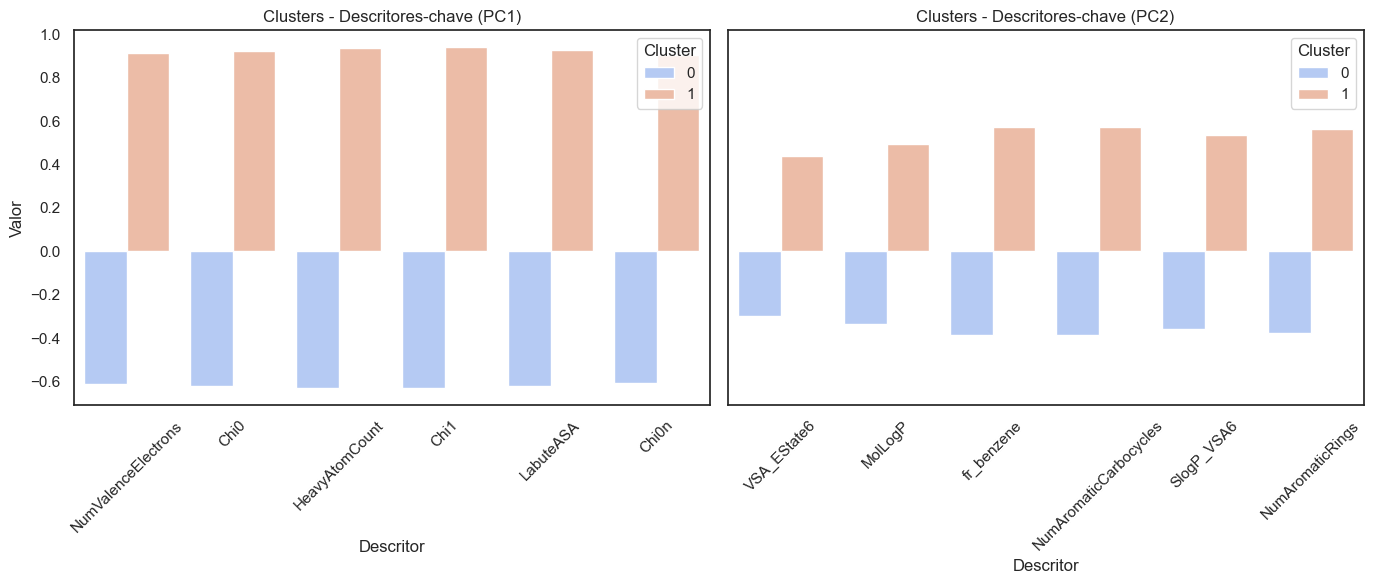

In [ ]:
# Supondo que 'features_scaled' s√£o os dados normalizados e 'clusters' s√£o os r√≥tulos do KMeans
features_clustered = pd.DataFrame(features_scaled, columns=features_clean.drop(columns=['Y']).columns)
features_clustered['Cluster'] = clusters

# Calcular a m√©dia de cada descritor por cluster
cluster_profile = features_clustered.groupby('Cluster').mean().T  # transposto para que descritores fiquem no √≠ndice

# Long format para PC1
cluster_profile_pc1 = cluster_profile.loc[top_pc1.index].reset_index().melt(id_vars='index', var_name='Cluster', value_name='Valor')
cluster_profile_pc1.rename(columns={'index': 'Descritor'}, inplace=True)

# Long format para PC2
cluster_profile_pc2 = cluster_profile.loc[top_pc2.index].reset_index().melt(id_vars='index', var_name='Cluster', value_name='Valor')
cluster_profile_pc2.rename(columns={'index': 'Descritor'}, inplace=True)

# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# PC1
sns.barplot(data=cluster_profile_pc1, x='Descritor', y='Valor', hue='Cluster', palette='coolwarm', ax=axes[0])
axes[0].set_title("Clusters - Descritores-chave (PC1)")
plt.setp(axes[0].get_xticklabels(), rotation=45)

# PC2
sns.barplot(data=cluster_profile_pc2, x='Descritor', y='Valor', hue='Cluster', palette='coolwarm', ax=axes[1])
axes[1].set_title("Clusters - Descritores-chave (PC2)")
plt.setp(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Os gr√°ficos apresentam os descritores moleculares mais relevantes para separa√ß√£o dos clusters obtidos pelo K-Means, conforme proje√ß√£o nos dois primeiros componentes principais (PC1 e PC2) da an√°lise de componentes principais (PCA).

**Painel da Esquerda ‚Äì PC1**

Representa os descritores com maior peso na primeira componente principal, que explicou boa parte da vari√¢ncia entre os clusters:

    Cluster 0 (azul): valores mais baixos consistentemente.
    Cluster 1 (laranja): valores mais altos.

**Principais descritores destacados:**

    - NumValenceElectrons, HeavyAtomCount: relacionados ao tamanho e complexidade da mol√©cula.
    - Chi0, Chi1, Chi0n: √≠ndices topol√≥gicos associados √† conectividade e ramifica√ß√µes.
    - LabuteASA: estimativa da √°rea de superf√≠cie acess√≠vel ao solvente, relacionada √† hidrofobicidade.

O cluster 1 agrupa compostos maiores e mais conectados, enquanto o cluster 0 concentra compostos menores e mais simples.


**Painel da Direita ‚Äì PC2**

Representa os descritores que mais contribu√≠ram para a segunda componente principal, separando os clusters de forma ortogonal √† PC1.

**Descritores relevantes:**

    - VSA_Estate6, SlogP_VSA6: hidrofobicidade e superf√≠cie polar.
    - MolLogP: medida da lipofilicidade (coeficiente de parti√ß√£o).
    - f_benzene, NumAromaticRings, NumAromaticCarbocycles: presen√ßa de an√©is arom√°ticos.

O cluster 1 tende a ter maior aromaticidade e lipofilicidade, enquanto o cluster 0 possui menos estruturas arom√°ticas e √© potencialmente mais polar.


A separa√ß√£o dos clusters parece ser influenciada por:
- Tamanho e complexidade molecular (PC1).
- Aromaticidade e propriedades f√≠sico-qu√≠micas como logP e √°rea de superf√≠cie (PC2).

### 3.4 Visualiza√ß√£o das vari√°veis mais informativas

#### 3.4.1 Mutual information entre descritores e Y

In [ ]:
# Calcular os scores de mutual information entre as features e a vari√°vel alvo
mi_scores = mutual_info_classif(features_clean.drop(columns=['Y']), features_clean['Y'], random_state=42)

# Criar DataFrame com os nomes das vari√°veis e seus scores
mi_df = pd.DataFrame({
    'Variable': features_clean.drop(columns=['Y']).columns,
    'MI': mi_scores
})

# Ordenar do mais informativo para o menos
mi_df = mi_df.sort_values(by='MI', ascending=False)

#### 3.4.2 Histogramas das 6 vari√°veis mais informativas

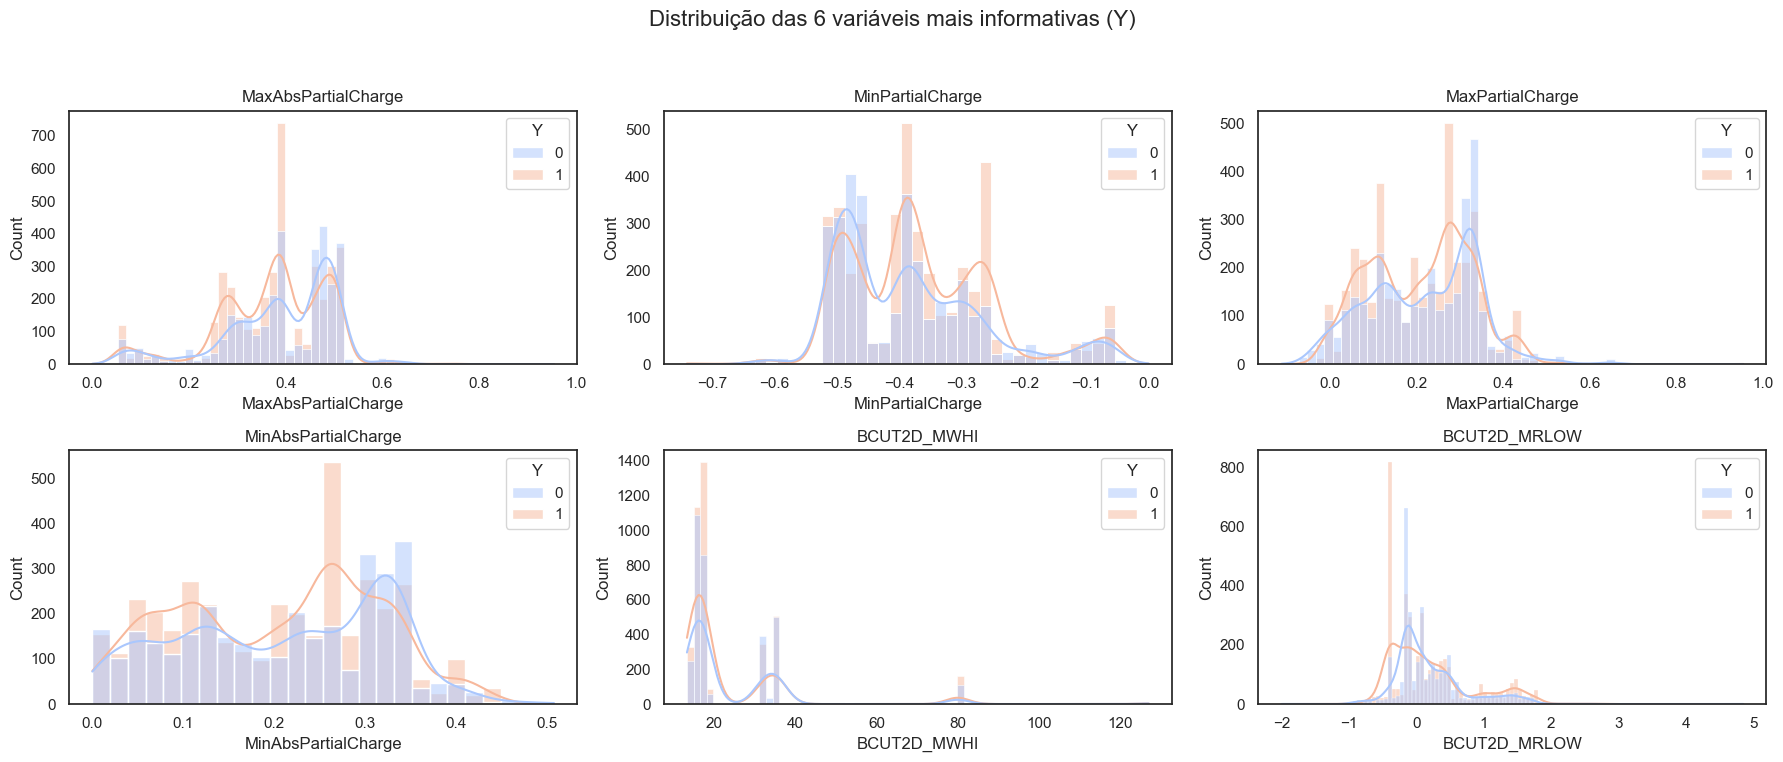

In [ ]:
# Selecionar s√≥ as 6 vari√°veis com maior mutual information
top_vars = mi_df.head(6)

# Criar figura √∫nica com 2 linhas e 3 colunas
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
axs = axs.flatten()  # transforma em vetor para indexar facilmente

for i, var in enumerate(top_vars['Variable']):
    sns.histplot(data=features_clean, x=var, hue='Y', kde=True, palette='coolwarm', ax=axs[i])
    axs[i].set_title(f'{var}')

# Desativar eixos vazios (caso hajam menos de 6 vari√°veis, por seguran√ßa)
for j in range(len(top_vars), len(axs)):
    axs[j].axis('off')

plt.suptitle("Distribui√ß√£o das 6 vari√°veis mais informativas (Y)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Os gr√°ficos representam a distribui√ß√£o das 6 vari√°veis mais relevantes para distinguir entre compostos mutag√©nicos (Y=1) e n√£o-mutag√©nicos (Y=0). Cada histograma compara a densidade das amostras em ambas as classes, permitindo observar padr√µes discriminativos.

**1. MaxAbsPartialCharge**

    - Reflete o maior valor absoluto de carga parcial num √°tomo da mol√©cula
    - Compostos mutag√©nicos (laranja) tendem a ter uma distribui√ß√£o ligeiramente mais concentrada (0.35‚Äì0.45)
    - N√£o-mutag√©nicos (azul) apresentam maior dispers√£o e valores ligeiramente mais altos.

**2. MinPartialCharge**

    - Reflete a menor carga parcial (mais negativa)
    - Mutag√©nicos tendem a concentrar-se em torno de -0.4, enquanto n√£o-mutag√©nicos possuem cauda mais alongada √† esquerda, com valores mais negativos
    - Pode indicar presen√ßa de √°tomos mais eletronegativos nos compostos n√£o-mutag√©nicos

**3. MaxPartialCharge**

    - Valor mais positivo de carga parcial
    - Ambas as classes s√£o relativamente similares, mas os n√£o-mutag√©nicos mostram leve deslocamento √† direita, indicando cargas parciais positivas mais altas em alguns casos

**4. MinAbsPartialCharge**

    - M√≥dulo da menor carga parcial (sem sinal)
    - Os n√£o-mutag√©nicos mostram uma tend√™ncia de valores mais elevados, sugerindo maior polaridade extrema em regi√µes da mol√©cula

**5. BCUT2D_MWHI**

    - Descritor BCUT ponderado pelo peso at√¥mico (alto valor)
    - Mutag√©nicos tendem a ter valores mais altos, possivelmente indicando maior diversidade estrutural ou presen√ßa de √°tomos pesados

**6. BCUT2D_MRLOW**

    - BCUT ponderado pela molar refratividade (baixo valor)
    - Mutag√©nicos mostram maior varia√ß√£o e valores mais positivos, sugerindo diferen√ßas na flexibilidade ou compacta√ß√£o eletr√≥nica

### 3.6 UMAP (Uniform Manifold Approximation and Projection)

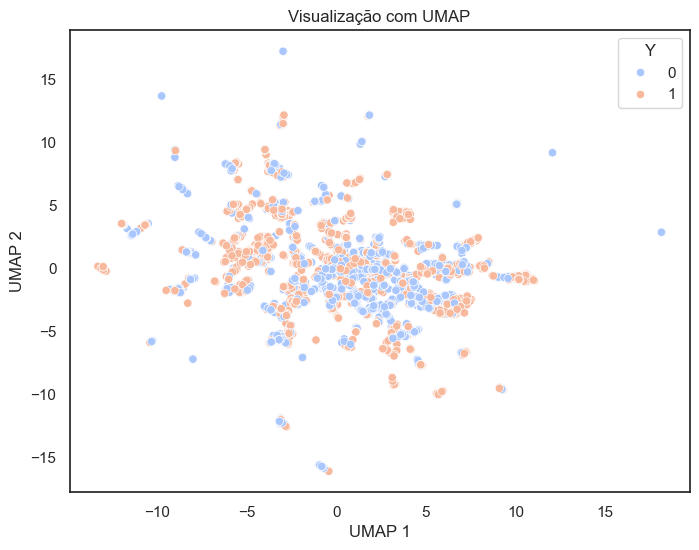

In [ ]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=outputs_df["Y"], palette='coolwarm')
plt.title("Visualiza√ß√£o com UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


O gr√°fico tem como objetivo representar os dados em 2D, preservando tanto a estrutura local quanto global.

    üîµ Y = 0 (n√£o mutag√©nico)
    üü† Y = 1 (mutag√©nico)

**Distribui√ß√£o naturalista:**
- Os pontos n√£o est√£o for√ßados a uma forma linear ou cartesiana - caracter√≠stico do UMAP.

**Agrupamentos vis√≠veis (suaves):**
- Apesar de n√£o haver uma separa√ß√£o expl√≠cita entre as classes, √© poss√≠vel observar tend√™ncias de agrupamento suave por cor. Algumas regi√µes parecem ter uma concentra√ß√£o maior de uma das classes.

**Sobreposi√ß√£o significativa:**
- A aus√™ncia de separa√ß√£o clara nos dados com base apenas nos dois eixos UMAP ou que os descritores moleculares utilizados n√£o s√£o suficientes para discriminar bem entre as classes.

**Escala assim√©trica e dispers√£o n√£o uniforme:**
- Os dados est√£o espalhados principalmente entre valores positivos no eixo UMAP1 e valores entre 0‚Äì25 no UMAP2

A visualiza√ß√£o UMAP confirma que os dados possuem estrutura interna, mas com alta sobreposi√ß√£o entre classes.

N√£o h√° separa√ß√£o linear ou agrupamentos evidentes ‚Äî o que √© esperado se a distin√ß√£o entre as classes depende de rela√ß√µes complexas entre m√∫ltiplos descritores.

### 3.7 t-SNE (t-distributed Stochastic Neighbor Embedding)

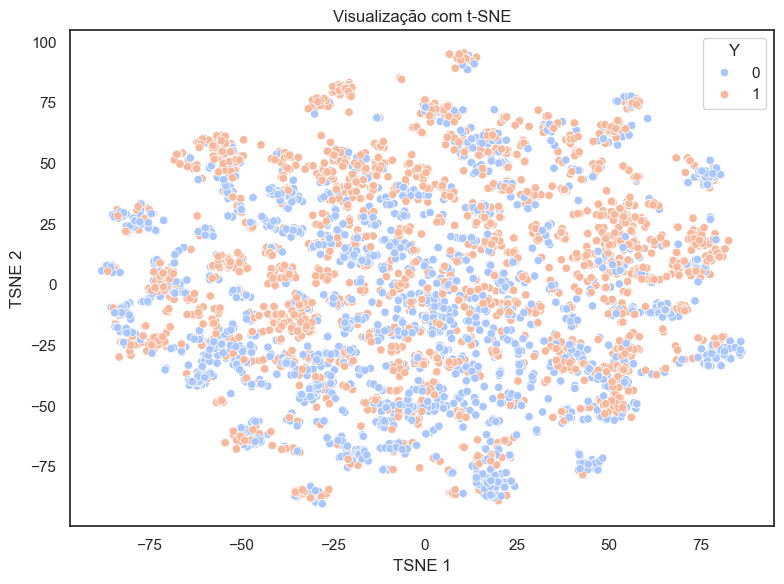

In [ ]:
# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(features_scaled)

# Visualizar resultados
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["Y"] = outputs_df["Y"]

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Y", palette='coolwarm')
plt.title("Visualiza√ß√£o com t-SNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.tight_layout()
plt.show()

O gr√°fico tem o objetivo de preservar rela√ß√µes locais entre os pontos de alta dimens√£o em um espa√ßo 2D ‚Äî ou seja, colocar pr√≥ximos no plano os pontos que s√£o similares nos dados originais.

    üîµ Y = 0 (n√£o mutag√©nico)
    üü† Y = 1 (mutag√©nico)

**Preserva√ß√£o local aparente:**
- Algumas microestruturas com pontos da mesma cor pr√≥ximos indicam que t-SNE conseguiu preservar vizinhan√ßas locais dos dados originais.

**Distribui√ß√£o rica e n√£o linear:**
- O t-SNE revela complexidades n√£o captadas pelo PCA, com padr√µes curvos e espalhados - rela√ß√µes s√£o n√£o lineares.

**Alta sobreposi√ß√£o entre as classes:**
- As classes est√£o muito intercaladas e n√£o formam clusters bem definidos

**Interpreta√ß√£o n√£o trivial:**
- t-SNE n√£o preserva dist√¢ncias globais nem varia√ß√µes marginais como o PCA. N√£o √© poss√≠vel afirmar que "grupos" no gr√°fico s√£o verdadeiramente distintos no espa√ßo original.

O t-SNE refor√ßa a dificuldade de separa√ß√£o clara entre as classes 0 e 1.

Apesar de revelar algumas zonas com maior concentra√ß√£o de uma classe, n√£o h√° um padr√£o suficientemente definido para justificar clustering puro.

#### 3.8 Avalia√ß√£o do Clustering - Silhouette_score

Silhouette Score para K-Means com k=2: 0.136


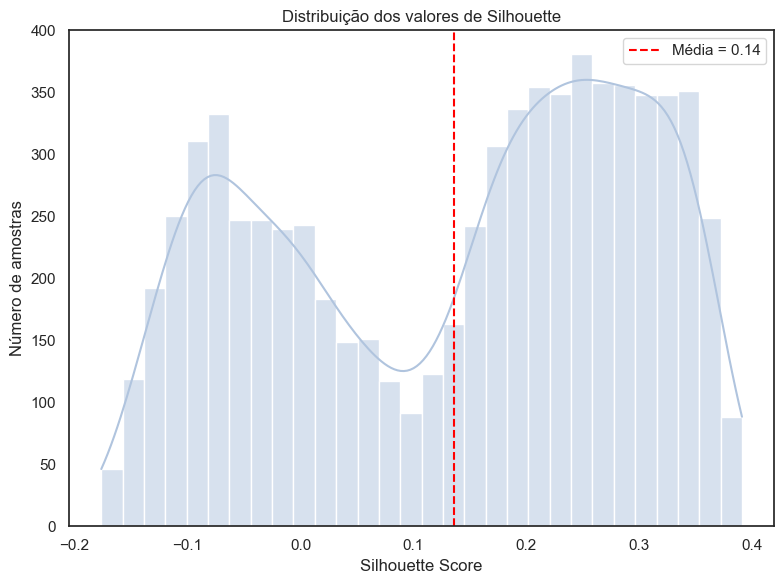

In [ ]:
# Avalia√ß√£o do clustering com silhouette score
sil_score = silhouette_score(features_scaled, clusters)
print(f"Silhouette Score para K-Means com k=2: {sil_score:.3f}")

sil_values = silhouette_samples(features_scaled, clusters)

plt.figure(figsize=(8,6))
sns.histplot(sil_values, bins=30, kde=True, color='lightsteelblue')
plt.axvline(sil_score, color='red', linestyle='--', label=f'M√©dia = {sil_score:.2f}')
plt.title("Distribui√ß√£o dos valores de Silhouette")
plt.xlabel("Silhouette Score")
plt.ylabel("N√∫mero de amostras")
plt.legend()
plt.tight_layout()
plt.show()


O valor de silhouette ajuda a avaliar a coes√£o e separa√ß√£o dos clusters. Valores mais pr√≥ximos de 1 indicam melhor separa√ß√£o.

**Valor M√©dio = 0.136**
- Indica baixa coes√£o e separa√ß√£o entre os clusters. Um valor abaixo de 0.25 sugere estrutura fraca ou inexistente de clusters nos dados.

**Distribui√ß√£o bimodal**
- A distribui√ß√£o apresenta dois picos: um em torno de -0.1 e outro em +0.25. Uma parte dos pontos est√° mal atribu√≠da (valores negativos). Outra parte parece estar razoavelmente agrupada.

**Valores negativos (~-0.2 at√© 0):**
- Um n√∫mero significativo de pontos tem scores negativos ‚Üí prov√°vel sobreposi√ß√£o entre clusters ou fronteiras mal definidas.

O KMeans est√° a for√ßar uma separa√ß√£o em 2 grupos sem uma estrutura natural clara.

Isso √© coerente com:
- O gr√°fico PCA ‚Üí onde as classes 0 e 1 se sobrep√µem.
- As proje√ß√µes UMAP e t-SNE ‚Üí tamb√©m mostraram forte mistura entre classes.
- A an√°lise do cotovelo ‚Üí indicava poss√≠vel melhoria at√© k=2

## 4. RDKit - Representa√ß√£o Visual dos Compostos-Chave

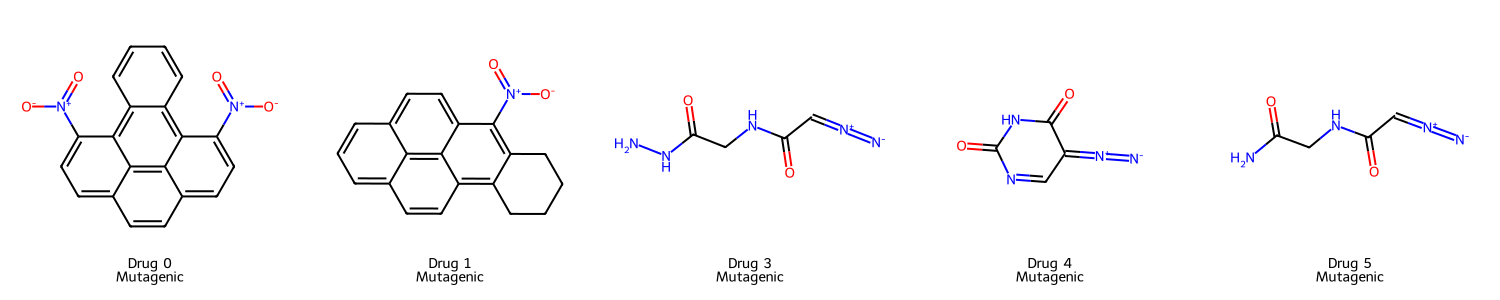

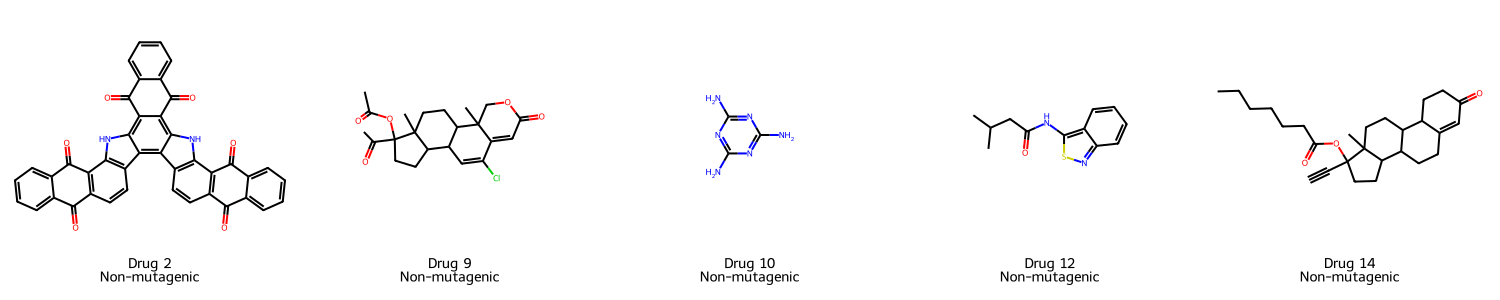

In [ ]:
# Obter os 5 primeiros compostos mutag√©nicos e n√£o mutag√©nicos
mut_df = outputs_df[outputs_df["Y"] == 1].head()
nonmut_df = outputs_df[outputs_df["Y"] == 0].head()

# Criar mol√©culas
mol_mut = [Chem.MolFromSmiles(s) for s in mut_df["smiles"]]
mol_nonmut = [Chem.MolFromSmiles(s) for s in nonmut_df["smiles"]]

# Criar legendas com ID (ou qualquer coluna relevante)
legends_mut = [f"{row['ids']}\nMutagenic" for _, row in mut_df.iterrows()]
legends_nonmut = [f"{row['ids']}\nNon-mutagenic" for _, row in nonmut_df.iterrows()]

# Gerar imagens
img_mut = Draw.MolsToGridImage(mol_mut, molsPerRow=5, subImgSize=(300, 300), legends=legends_mut)
img_nonmut = Draw.MolsToGridImage(mol_nonmut, molsPerRow=5, subImgSize=(300, 300), legends=legends_nonmut)

# Mostrar
display(img_mut)
display(img_nonmut)


Nesta etapa, foi utilizada a biblioteca RDKit para gerar uma representa√ß√£o visual dos compostos qu√≠micos selecionados do conjunto de dados, com o objetivo de comparar exemplos de compostos mutag√©nicos e n√£o mutag√©nicos.

- Estes compostos podem ser considerados representativos ("centroide-like") dos respectivos clusters em an√°lises anteriores, como K-Means.

Foram selecionados os 5 primeiros compostos mutag√™nicos (Y=1) e 5 n√£o mutag√™nicos (Y=0) a partir do DataFrame.

As estruturas moleculares foram convertidas a partir de strings SMILES usando Chem.MolFromSmiles.

**As imagens foram geradas com Draw.MolsToGridImage, apresentando:**
    
    - A estrutura qu√≠mica
    - O ID da mol√©cula
    - A classifica√ß√£o (Mutagenic/Non-mutagenic)

**Compostos Mutag√©nicos:**
- Muitos deles apresentam grupos nitro (-NO‚ÇÇ) ou sistemas arom√°ticos planos, frequentemente associados a potencial mutag√™nico (ex: intercalantes de DNA).

- Apresentam maior conjuga√ß√£o eletr√¥nica e grupos funcionais potencialmente reativos.

**Compostos N√£o Mutag√©nicos:**
- Estruturas mais complexas ou volumosas, menos planas.
- Presen√ßa de grupos apolares ou hetero√°tomos isolados, menos associados √† reatividade com DNA.

# 5. Analise Supervisionada

#### 5.1 Lazy Predict com Stratified K-Fold Cross Validation

Para avaliar de forma robusta o desempenho de diversos modelos de classifica√ß√£o aplicados ao problema de previs√£o da mutagenicidade de compostos qu√≠micos, utilizamos a biblioteca LazyPredict em conjunto com Stratified K-Fold Cross Validation com cinco folds.

O objetivo √© comparar automaticamente m√∫ltiplos classificadores supervisionados de forma a escolher os cinco melhores e aplica-los manualmente. Para isso, empregamos o LazyClassifier, que testa dezenas de algoritmos de machine learning com os seus par√¢metros padr√£o, avaliando m√©tricas relevantes como Acuraccy, Balanced Accuracy, ROC AUC (), F1-score e Time Taken.

O uso de Stratified K-Fold, garante que a propor√ß√£o entre classes (mutag√©nico vs. n√£o mutag√©nico) √© mantida em cada fold. Isto assegura uma avalia√ß√£o mais equilibrada, reduz a variabilidade nos resultados e evita conclus√µes enviesadas devido √† distribui√ß√£o desigual das classes. No contexto deste trabalho, permite comparar de forma fi√°vel o desempenho m√©dio de v√°rios classificadores sobre o conjunto de dados.


**O script implementado realiza os seguintes passos:**

**Divis√£o inicial dos dados:**
 - O conjunto total de dados foi dividido em 80% para treino e 20% para teste, mantendo a propor√ß√£o original das classes (mutag√©nicos vs. n√£o mutag√©nicos) atrav√©s de estratifica√ß√£o. Esta divis√£o assegura a exist√™ncia de um conjunto de teste independente, reservado exclusivamente para avalia√ß√£o final dos modelos.

**Valida√ß√£o cruzada estratificada sobre o treino (Stratified K-Fold):**
 - O subconjunto de treino (80%) foi submetido a uma valida√ß√£o cruzada estratificada com 5 folds, garantindo que cada parti√ß√£o mantinha a propor√ß√£o entre classes. Para cada fold, foram definidos conjuntos de treino (80%) e valida√ß√£o (20%).

**Aplica√ß√£o do LazyClassifier:**
- Em cada fold, foi utilizado o LazyClassifier

**Agrega√ß√£o e compara√ß√£o dos modelos:**
- Os resultados de todos os folds foram combinados e agregados por modelo, permitindo calcular as m√©dias das m√©tricas de desempenho. Isso permitiu comparar os classificadores de forma justa e robusta, sem sobreajuste, utilizando apenas os dados de treino.

Este procedimento garante que a escolha dos modelos mais promissores √© feita com base numa avalia√ß√£o rigorosa, sem expor os dados de teste antes da fase final. O conjunto de teste separado (20%) ser√° posteriormente utilizado para avaliar os modelos selecionados de forma definitiva.

In [ ]:
# Separar 80% treino e 20% teste
X_train_full, X_test, y_train_full, y_test = train_test_split(
    features_scaled, outputs_df["Y"].values, test_size=0.2, stratify=outputs_df["Y"], random_state=42
)

# Stratified k-Fold nos 80% de treino
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Armazenar resultados
fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\nFold {fold+1}")

    X_train, X_val = X_train_full[train_idx], X_train_full[test_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[test_idx]

    clf = LazyClassifier(verbose=0, ignore_warnings=True)
    models, predictions = clf.fit(X_train, X_val, y_train, y_val)

    models["Fold"] = fold + 1
    fold_results.append(models)

# Combinar resultados de todos os folds
results_df = pd.concat(fold_results).reset_index()

# Agrupar corretamente e tirar m√©dia
mean_results = results_df.groupby("Model")[["Accuracy", "Balanced Accuracy", "ROC AUC", "F1 Score", "Time Taken"]].mean()

# Ordenar por Accuracy
mean_results = mean_results.sort_values(by="Accuracy", ascending=False)

# Ver top 10
display(mean_results.head(10))



Fold 1


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 4654, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546412 -> initscore=0.186183
[LightGBM] [Info] Start training from score 0.186183

Fold 2


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22456
[LightGBM] [Info] Number of data points in the train set: 4654, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546412 -> initscore=0.186183
[LightGBM] [Info] Start training from score 0.186183

Fold 3


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22461
[LightGBM] [Info] Number of data points in the train set: 4654, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546412 -> initscore=0.186183
[LightGBM] [Info] Start training from score 0.186183

Fold 4


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2544, number of negative: 2111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.562465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22458
[LightGBM] [Info] Number of data points in the train set: 4655, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546509 -> initscore=0.186576
[LightGBM] [Info] Start training from score 0.186576

Fold 5


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22454
[LightGBM] [Info] Number of data points in the train set: 4655, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546294 -> initscore=0.185709
[LightGBM] [Info] Start training from score 0.185709


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                        
ExtraTreesClassifier            0.83               0.83     0.83      0.83   
RandomForestClassifier          0.82               0.82     0.82      0.82   
LGBMClassifier                  0.82               0.82     0.82      0.82   
XGBClassifier                   0.82               0.82     0.82      0.82   
BaggingClassifier               0.81               0.81     0.81      0.81   
NuSVC                           0.81               0.81     0.81      0.81   
SVC                             0.81               0.81     0.81      0.81   
KNeighborsClassifier            0.78               0.78     0.78      0.78   
CalibratedClassifierCV          0.77               0.77     0.77      0.77   
LinearDiscriminantAnalysis      0.77               0.77     0.77      0.77   

                            Time Taken  
Model                                   
ExtraTreesClassifier              1.83  
RandomForestClassifier            4.48  
LGBMClassifier                    2.21  
XGBClassifier                     2.86  
BaggingClassifier                 6.57  
NuSVC                             7.04  
SVC                               6.55  
KNeighborsClassifier              0.12  
CalibratedClassifierCV           34.16  
LinearDiscriminantAnalysis        0.22

##### **Resultados**

Os resultados obtidos mostram que os classificadores **ExtraTreesClassifier**, **RandomForestClassifier**, **LGBMClassifier** e **XGBClassifier** foram consistentemente os mais eficazes, apresentando valores m√©dios de Acuraccy, Balanced Accuracy, ROC AUC (), F1-score e Time Taken iguais ou superiores a 0.82, com tempos de execu√ß√£o relativamente baixos.

Estes resultados indicam que esses modelos s√£o fortes candidatos √† implementa√ß√£o final. A fase seguinte do trabalho consistir√° em treinar manualmente os modelos mais promissores usando a totalidade dos dados de treino (80%) e avaliar o seu desempenho final no conjunto de teste independente (20%), que n√£o foi utilizado em nenhum momento da valida√ß√£o.

##### **Ajuste e Avalia√ß√£o Final dos Modelos Selecionados**

Para cada um destes modelos, foi aplicado o mesmo processo de fine-tuning e avalia√ß√£o final, descrito a seguir.

**Ajuste de hiperpar√¢metros com GridSearchCV:**
- Para cada modelo, foi definida uma grelha de hiperpar√¢metros relevantes, baseada na documenta√ß√£o oficial. O GridSearchCV foi utilizado com valida√ß√£o cruzada estratificada (5 folds) e a m√©trica de pbalenced accuracy como crit√©rio de otimiza√ß√£o. Esta m√©trica foi escolhida por ser mais adequada em problemas com poss√≠vel desequil√≠brio de classes, como √© o caso da predi√ß√£o de mutagenicidade.

**Treino do modelo otimizado:**
- O melhor conjunto de hiperpar√¢metros encontrado foi utilizado para treinar cada modelo sobre a totalidade do conjunto de treino (80% dos dados), que havia sido previamente separado antes da valida√ß√£o cruzada.

**Avalia√ß√£o final no conjunto de teste:**
- Com os modelos finais treinados, foram feitas previs√µes sobre o conjunto de teste (20% dos dados, n√£o utilizado anteriormente). Para cada modelo, foram geradas a matriz de confus√£o e o relat√≥rio de classifica√ß√£o, contendo as principais m√©tricas de desempenho: precision, recall, F1-score, e accuracy.

Este processo garante uma compara√ß√£o justa entre os modelos, permitindo avaliar com confian√ßa qual deles apresenta o melhor desempenho realista para o problema de predi√ß√£o da mutagenicidade com base nas representa√ß√µes moleculares dispon√≠veis.

#### 5.2 ExtraTreesClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html

O ExtraTreesClassifier (Extremely Randomized Trees) √© um ensemble de √°rvores de decis√£o que se baseia na t√©cnica de bagging. Este modelo escolhe os pontos de divis√£o de forma completamente aleat√≥ria, o que aumenta a diversidade entre as √°rvores e reduz a vari√¢ncia. √â conhecido por ser muito r√°pido, robusto a overfiting, e eficiente em datasets com muitas vari√°veis.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(
    ExtraTreesClassifier(random_state=42),
    param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)
print("Melhores Par√¢metros:", grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores Par√¢metros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


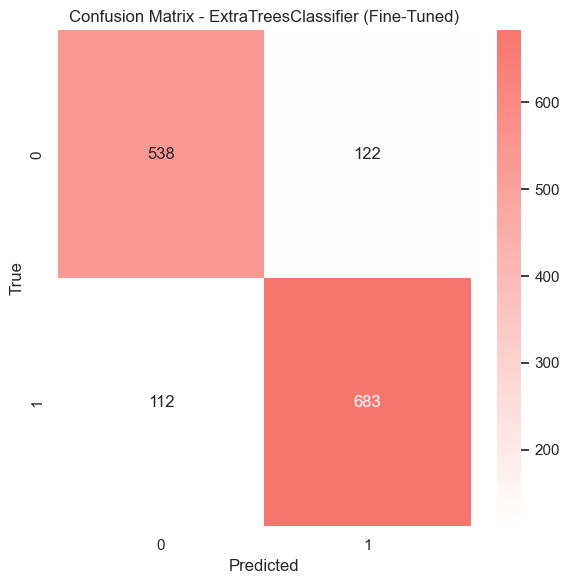


Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0     0.8277    0.8152    0.8214       660
           1     0.8484    0.8591    0.8538       795

    accuracy                         0.8392      1455
   macro avg     0.8381    0.8371    0.8376      1455
weighted avg     0.8390    0.8392    0.8391      1455



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Definir o modelo com os melhores par√¢metros
best_et = ExtraTreesClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=500,
    random_state=42
)

# Treinar com todos os dados de treino
best_et.fit(X_train_full, y_train_full)

# Fazer previs√µes no conjunto de teste
y_pred = best_et.predict(X_test)

# Previs√µes
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_et.classes_

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", ["#FFFFFF", "#F8766D"]
)

# Plot
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - ExtraTreesClassifier (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.tight_layout()
plt.show()

# Gerar e mostrar o relat√≥rio de classifica√ß√£o
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred, digits=4))


#### 5.3 RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

O RandomForestClassifier tamb√©m √© um ensemble de √°rvores de decis√£o baseado em bagging, mas escolhe os pontos de divis√£o com base em medidas como a entropia ou o √≠ndice de Gini. √â um dos modelos mais utilizados em tarefas de classifica√ß√£o pela sua alta estabilidade e desempenho consistente, mesmo sem grandes afina√ß√µes de par√¢metros.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)
print("Melhores Par√¢metros", grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores Par√¢metros {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


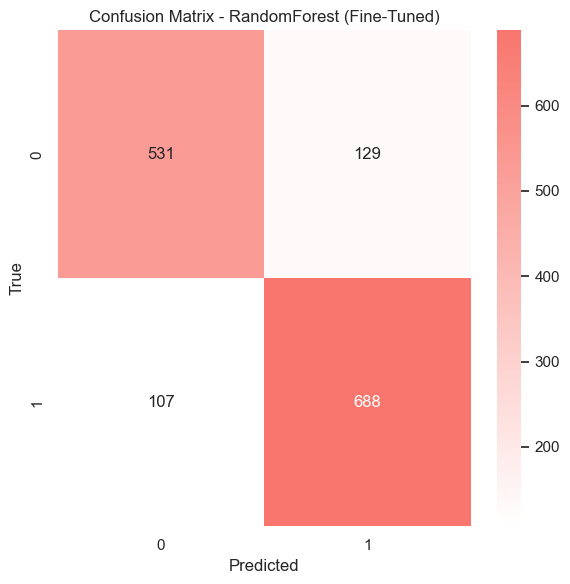


Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0     0.8323    0.8045    0.8182       660
           1     0.8421    0.8654    0.8536       795

    accuracy                         0.8378      1455
   macro avg     0.8372    0.8350    0.8359      1455
weighted avg     0.8377    0.8378    0.8375      1455



In [ ]:
# Definir o modelo com os melhores par√¢metros
best_rf = RandomForestClassifier(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=500,
    random_state=42
)

# Treinar com todos os dados de treino
best_rf.fit(X_train_full, y_train_full)

# Fazer previs√µes no conjunto de teste
y_pred = best_rf.predict(X_test)

# Previs√µes
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_rf.classes_

# Plot
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - RandomForest (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.tight_layout()
plt.show()

# Gerar e mostrar o relat√≥rio de classifica√ß√£o
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred, digits=4))


#### 5.4 LGBMClassifier

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

O LGBMClassifier faz parte da fam√≠lia de algoritmos gradient boosting, implementado na biblioteca LightGBM. √â especialmente concebido para ser altamente eficiente e escal√°vel, utilizando histogramas para acelerar o treino. Destaca-se pelo seu excelente desempenho em datasets tabulares com grande n√∫mero de inst√¢ncias e atributos.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30],
}

grid = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)

print("Melhores Par√¢metros:", grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 3179, number of negative: 2639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22666
[LightGBM] [Info] Number of data points in the train set: 5818, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546408 -> initscore=0.186167
[LightGBM] [Info] Start training from score 0.186167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Info] Number of positive: 3179, number of negative: 2639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22666
[LightGBM] [Info] Number of data points in the train set: 5818, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546408 -> initscore=0.186167
[LightGBM] [Info] Start training from score 0.186167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


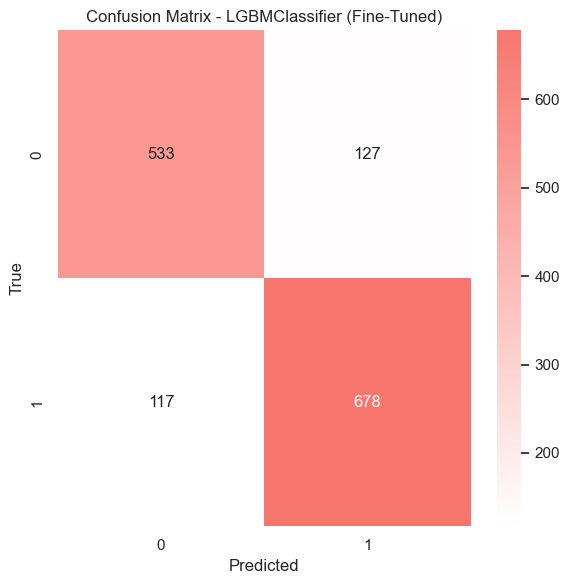


Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0     0.8200    0.8076    0.8137       660
           1     0.8422    0.8528    0.8475       795

    accuracy                         0.8323      1455
   macro avg     0.8311    0.8302    0.8306      1455
weighted avg     0.8321    0.8323    0.8322      1455



In [ ]:
# Definir o modelo com os melhores par√¢metros
best_lgbm = LGBMClassifier(learning_rate = 0.1,
                           max_depth = 10,
                           min_child_samples = 20,
                           n_estimators = 500,
                           num_leaves = 31
                           )

# Treinar o modelo no conjunto de treino
best_lgbm.fit(X_train_full, y_train_full)

# Previs√µes no conjunto de teste
y_pred = best_lgbm.predict(X_test)

# Matriz de confus√£o
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_lgbm.classes_

# Gr√°fico da matriz de confus√£o
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - LGBMClassifier (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Relat√≥rio de classifica√ß√£o
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred, digits=4))

#### 5.5 XGBClassifier

https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.ensemble.XGBClassifier

O XGBClassifier √© um modelo de gradient boosting muito popular, proveniente da biblioteca XGBoost. Utiliza regulariza√ß√£o expl√≠cita (L1 e L2), o que o torna mais resistente ao sobreajuste. √â conhecido pelo seu equil√≠brio entre precis√£o e velocidade, sendo frequentemente utilizado em ci√™ncia de dados.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)

print("Melhores Par√¢metros:", grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Melhores Par√¢metros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


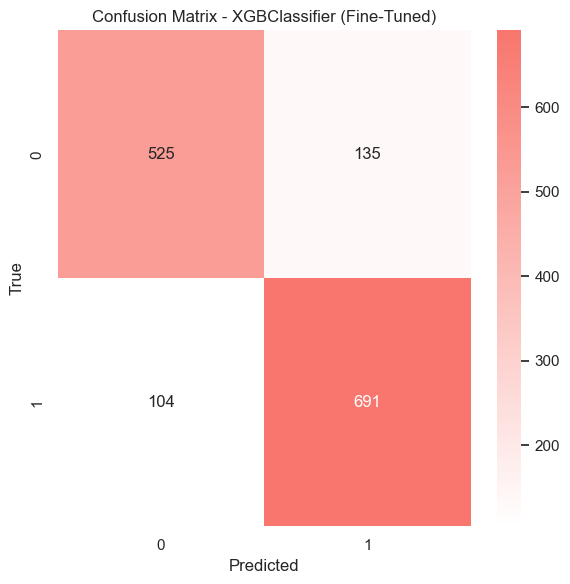


Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0     0.8347    0.7955    0.8146       660
           1     0.8366    0.8692    0.8526       795

    accuracy                         0.8357      1455
   macro avg     0.8356    0.8323    0.8336      1455
weighted avg     0.8357    0.8357    0.8353      1455



In [ ]:
# Definir o modelo com os melhores par√¢metros
best_xgb = XGBClassifier(
    colsample_bytree = 1.0,
    learning_rate = 0.1,
    max_depth0 = 10,
    n_estimators = 200,
    subsample = 1.0
      )

# Treinar o modelo com todos os dados de treino
best_xgb.fit(X_train_full, y_train_full)

# Fazer previs√µes no conjunto de teste
y_pred = best_xgb.predict(X_test)

# Matriz de confus√£o
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_xgb.classes_

# Plot da matriz de confus√£o
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - XGBClassifier (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Relat√≥rio de classifica√ß√£o
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred, digits=4))


#### 5.6 Analise dos Resultados

##### **M√©tricas de Avalia√ß√£o**

Para avaliar o desempenho dos modelos, foram analisadas as matrizes de confus√£o e os relat√≥rios de classifica√ß√£o de cada um deles. Estes relat√≥rios apresentam diversas m√©tricas que permitem compreender a capacidade preditiva de cada modelo tanto de forma global como em rela√ß√£o a cada classe. Abaixo descrevem-se as principais m√©tricas utilizadas:

**Precision:**
- Indica a propor√ß√£o de previs√µes positivas que estavam corretas. Um valor elevado de precis√£o significa que o modelo comete poucos falsos positivos.

**Recall:**
- Mede a propor√ß√£o de exemplos positivos corretamente identificados pelo modelo. Uma revoca√ß√£o alta indica que o modelo deteta bem a classe positiva, com poucos falsos negativos.

**F1-score:**
- √â a m√©dia harm√≥nica entre precision e recall. Serve como uma m√©trica de equil√≠brio entre as duas anteriores, especialmente √∫til quando existe algum desequil√≠brio entre classes.

**Support:**
- Representa o n√∫mero de ocorr√™ncias reais de cada classe no conjunto de teste. Embora n√£o seja uma m√©trica de desempenho, ajuda a contextualizar os valores obtidos.

**Accuracy:**
- Percentagem total de previs√µes corretas. Embora seja uma m√©trica geral intuitiva, pode ser enganadora em problemas com classes desequilibradas.

**Macro Avg / Weighted Avg:**

- Macro Average: m√©dia simples das m√©tricas de todas as classes, tratando todas com o mesmo peso.

- Weighted Average: m√©dia ponderada pelo n√∫mero de inst√¢ncias de cada classe, refletindo melhor o desempenho global quando h√° desequil√≠brio de classes.

##### **Compara√ß√£o de Modelos**

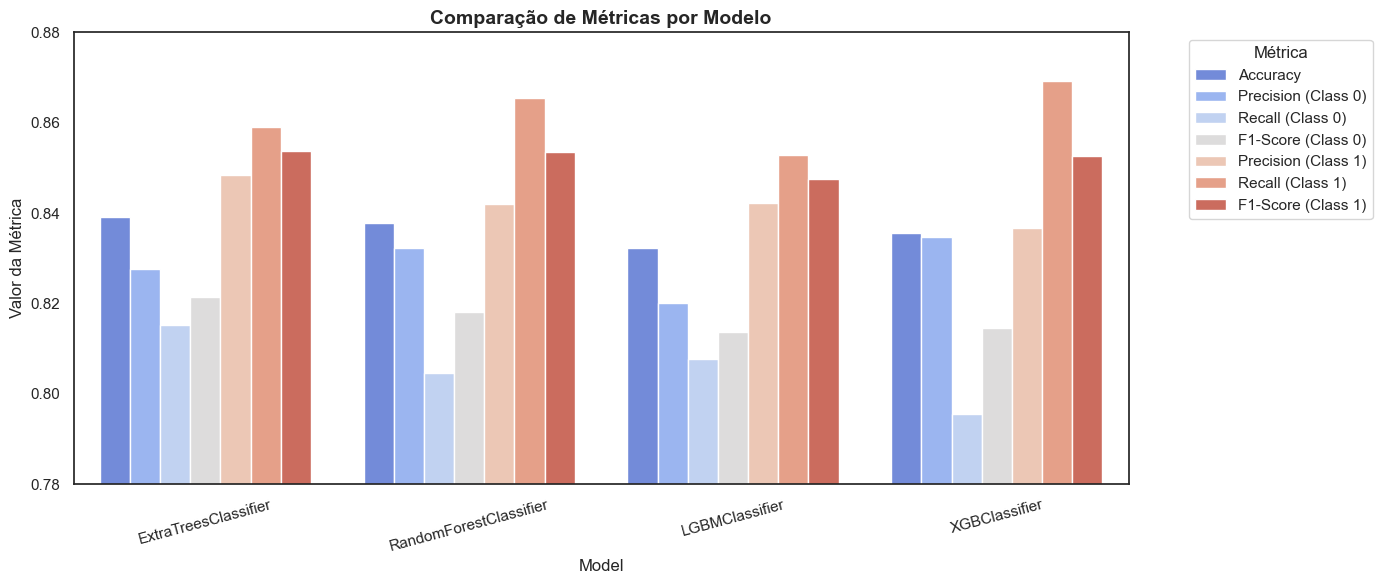

In [ ]:
# Dados das m√©tricas
data = {
    'Model': ['ExtraTreesClassifier', 'RandomForestClassifier', 'LGBMClassifier', 'XGBClassifier'],
    'Accuracy': [0.8392, 0.8378, 0.8323, 0.8357],
    'Precision (Class 0)': [0.8277, 0.8323, 0.8200, 0.8347],
    'Recall (Class 0)': [0.8152, 0.8045, 0.8076, 0.7955],
    'F1-Score (Class 0)': [0.8214, 0.8182, 0.8137, 0.8146],
    'Precision (Class 1)': [0.8484, 0.8421, 0.8422, 0.8366],
    'Recall (Class 1)': [0.8591, 0.8654, 0.8528, 0.8692],
    'F1-Score (Class 1)': [0.8538, 0.8536, 0.8475, 0.8526],
}

df = pd.DataFrame(data)

df_long = df.melt(id_vars='Model', var_name='M√©trica', value_name='Valor')

# Gr√°fico de barras agrupadas
plt.figure(figsize=(14, 6))
sns.barplot(data=df_long, x='Model', y='Valor', hue='M√©trica', palette='coolwarm')
plt.title('Compara√ß√£o de M√©tricas por Modelo', fontsize=14, weight='bold')
plt.ylabel('Valor da M√©trica')
plt.ylim(0.78, 0.88)
plt.xticks(rotation=15)
plt.legend(title='M√©trica', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Ap√≥s o ajuste dos hiperpar√¢metros, os quatro modelos foram avaliados com base no seu desempenho sobre o conjunto de teste. Todos eles apresentaram resultados muito pr√≥ximos, com accuracy global entre 83,2% e 83,9%, o que evidencia a robustez dos classificadores escolhidos.

- **ExtraTreesClassifier** foi o modelo com melhor desempenho global, alcan√ßando uma accuracy de 83,92%, com um F1-score de 0.8214 para a classe 0 e 0.8538 para a classe 1. Este modelo destacou-se por manter um bom equil√≠brio entre precision e recall nas duas classes, sendo ligeiramente mais eficaz na detec√ß√£o de compostos mutag√©nicos (classe 1), que √© a classe de maior interesse neste contexto.

- **RandomForestClassifier** apresentou um desempenho muito pr√≥ximo, com uma accuracy de 83,78% e um F1-score de 0.8182 (classe 0) e 0.8536 (classe 1). A ligeira diferen√ßa em rela√ß√£o ao ExtraTrees deve-se a uma taxa de falsos negativos um pouco superior na classe 0, ainda que tenha conseguido a maior recall para a classe 1 (86,54%).

- **XGBClassifier** obteve uma accuracy de 83,57%, destacando-se pela melhor precis√£o na classe 1 (0.8366) e um F1-score bastante competitivo (0.8526). No entanto, teve a maior taxa de falsos positivos para a classe 0, o que ligeiramente penalizou a sua taxa de recall.

- **LGBMClassifier**, embora muito consistente, apresenta-se com um desempenho ligeiramente inferior entre os quatro, com uma accuracy de 83,23%, F1-score de 0.8137 para a classe 0 e 0.8475 para a classe 1. Ainda assim, apresentou um comportamento equilibrado e est√°vel, o que o torna uma op√ß√£o v√°lida em contextos com maior restri√ß√£o de tempo computacional.

Globalmente, todos os modelos mostraram-se eficazes na predi√ß√£o da mutagenicidade, com ligeiras varia√ß√µes entre eles. O ExtraTreesClassifier e o RandomForestClassifier destacaram-se como as escolhas mais robustas e equilibradas, com uma vantagem minima para o **ExtraTreesClassifier** no conjunto de m√©tricas.